In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sys

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.model_selection import train_test_split

# from src.data_preparation import compute_work_item_times, split_times
from src.evaluate import rmsle

sys.path.append('..')  # '..' is the shortcut for the parent directory of the current working directory

%matplotlib inline
sns.set()

In [2]:
## Loading the data and replacing nulls with Start, Finish
file_path = (r"C:\Users\ljeffery\Documents\Data Science Challenge\gdsc2_public.csv")
df = pd.read_csv(file_path, sep=';', parse_dates=['timestamp'])
df.from_phase.fillna('Start', inplace=True)  
df.to_phase.fillna('End', inplace=True)
df.head()

timestamp  work_item work_type work_priority    domain  platform  \
0 2015-01-02 14:39:14  WI_000001  WT_00001      WP_00003  BD_00001  PL_00001   
1 2015-01-02 15:04:20  WI_000002  WT_00002      WP_00004  BD_00002  PL_00002   
2 2015-01-02 15:28:22  WI_000003  WT_00002      WP_00004  BD_00002  PL_00002   
3 2015-01-02 15:33:54  WI_000004  WT_00002      WP_00004  BD_00002  PL_00002   
4 2015-01-02 16:32:11  WI_000005  WT_00002      WP_00003  BD_00003  PL_00003   

          components from_phase to_phase from_resource to_resource  
0                NaN      Start  Analyze           NaN    ER_00043  
1  CO_00037/CO_00071      Start  Analyze           NaN    ER_00225  
2  CO_00037/CO_00071      Start  Analyze           NaN    ER_00225  
3  CO_00037/CO_00071      Start  Analyze           NaN    ER_00225  
4           CO_00113      Start  Analyze           NaN    ER_00206

In [3]:
##Checking the data types
df.dtypes

timestamp        datetime64[ns]
work_item                object
work_type                object
work_priority            object
domain                   object
platform                 object
components               object
from_phase               object
to_phase                 object
from_resource            object
to_resource              object
dtype: object

In [4]:
## the Function to get times - add columns for minutes and seconds - Will use seconds in duration as it has less null values
def compute_work_item_times(df: pd.DataFrame) -> pd.DataFrame:
    """
    Takes a DataFrame with the ticket data and computes the start time, end time,  duration and the
    duration_in_hours.
    :param df: As described above
    :return: As described above
    """
    # We can't be sure that NAs were already renamed. Do it again just to be sure.
    df.from_phase.fillna('Start', inplace=True)
    df.to_phase.fillna('End', inplace=True)

    relevant_columns = ['work_item', 'timestamp']
    start_times = df[df.from_phase == 'Start'][relevant_columns]
    end_times = df[df.to_phase == 'End'][relevant_columns]
    times = pd.merge(start_times, end_times, on='work_item', how='left')
    times.rename(columns={'timestamp_x': 'start', 'timestamp_y': 'end'}, inplace=True)
    times['duration'] = times['end'] - times['start']
    times['duration_in_days'] = times['duration'].apply(lambda x: round(x.total_seconds() / (24*3600), 2))
    times['duration_in_hours'] = times['duration'].apply(lambda x: round(x.total_seconds() / (3600), 2))
    times['duration_in_minutes'] = times['duration'].apply(lambda x: round(x.total_seconds() / (60), 2))
    times['duration_in_seconds'] = times['duration'].apply(lambda x: round(x.total_seconds(), 2))
    return times

In [5]:
## Running the duration function
times = compute_work_item_times(df)
times.head(10)

work_item               start                 end         duration  \
0  WI_000001 2015-01-02 14:39:14 2015-01-27 11:36:51 24 days 20:57:37   
1  WI_000002 2015-01-02 15:04:20 2015-01-14 09:46:37 11 days 18:42:17   
2  WI_000003 2015-01-02 15:28:22 2015-02-26 11:50:37 54 days 20:22:15   
3  WI_000004 2015-01-02 15:33:54 2015-01-28 09:11:05 25 days 17:37:11   
4  WI_000005 2015-01-02 16:32:11 2015-02-04 12:57:49 32 days 20:25:38   
5  WI_000006 2015-01-02 16:56:27 2015-02-04 12:57:26 32 days 20:00:59   
6  WI_000007 2015-01-03 14:33:10 2015-01-19 10:23:31 15 days 19:50:21   
7  WI_000008 2015-01-04 20:57:40 2015-01-13 08:58:33  8 days 12:00:53   
8  WI_000009 2015-01-04 21:28:12 2015-01-06 14:52:25  1 days 17:24:13   
9  WI_000010 2015-01-05 08:56:47 2015-02-25 08:17:57 50 days 23:21:10   

   duration_in_days  duration_in_hours  duration_in_minutes  \
0             24.87             596.96             35817.62   
1             11.78             282.70             16962.28   
2             54.85            1316.37             78982.25   
3             25.73             617.62             37057.18   
4             32.85             788.43             47305.63   
5             32.83             788.02             47280.98   
6             15.83             379.84             22790.35   
7              8.50             204.01             12240.88   
8              1.73              41.40              2484.22   
9             50.97            1223.35             73401.17   

   duration_in_seconds  
0            2149057.0  
1            1017737.0  
2            4738935.0  
3            2223431.0  
4            2838338.0  
5            2836859.0  
6            1367421.0  
7             734453.0  
8             149053.0  
9            4404070.0

In [7]:
## pulling out the features that will be needed for the model. 
work_items = (df.groupby([df['work_item'],df['work_type'], df['work_priority'],df['domain'],df['platform'], df['components'].fillna('tmp')])
              .apply(','.join).reset_index().replace({'components':{'tmp':np.nan}}))
work_items.head()
by_item = work_items[['work_item', 'work_type', 'work_priority', 'domain','platform','components']]
by_item.head(10).sort_values('work_item')

work_item work_type work_priority    domain  platform         components
0  WI_000001  WT_00001      WP_00003  BD_00001  PL_00001                NaN
1  WI_000002  WT_00002      WP_00004  BD_00002  PL_00002  CO_00037/CO_00071
2  WI_000003  WT_00002      WP_00004  BD_00002  PL_00002  CO_00037/CO_00071
3  WI_000004  WT_00002      WP_00004  BD_00002  PL_00002  CO_00037/CO_00071
4  WI_000005  WT_00002      WP_00003  BD_00003  PL_00003           CO_00113
5  WI_000006  WT_00002      WP_00003  BD_00003  PL_00003           CO_00113
6  WI_000007  WT_00002      WP_00003  BD_00001  PL_00001                NaN
7  WI_000008  WT_00002      WP_00003  BD_00003  PL_00003           CO_00113
8  WI_000009  WT_00002      WP_00003  BD_00004  PL_00004                NaN
9  WI_000010  WT_00002      WP_00003  BD_00003  PL_00003           CO_00113

In [8]:
#Joining the two dataframes
new_df = pd.merge(times, by_item, on = 'work_item')
new_df.head(10)

work_item               start                 end         duration  \
0  WI_000001 2015-01-02 14:39:14 2015-01-27 11:36:51 24 days 20:57:37   
1  WI_000002 2015-01-02 15:04:20 2015-01-14 09:46:37 11 days 18:42:17   
2  WI_000003 2015-01-02 15:28:22 2015-02-26 11:50:37 54 days 20:22:15   
3  WI_000004 2015-01-02 15:33:54 2015-01-28 09:11:05 25 days 17:37:11   
4  WI_000005 2015-01-02 16:32:11 2015-02-04 12:57:49 32 days 20:25:38   
5  WI_000006 2015-01-02 16:56:27 2015-02-04 12:57:26 32 days 20:00:59   
6  WI_000007 2015-01-03 14:33:10 2015-01-19 10:23:31 15 days 19:50:21   
7  WI_000008 2015-01-04 20:57:40 2015-01-13 08:58:33  8 days 12:00:53   
8  WI_000009 2015-01-04 21:28:12 2015-01-06 14:52:25  1 days 17:24:13   
9  WI_000010 2015-01-05 08:56:47 2015-02-25 08:17:57 50 days 23:21:10   

   duration_in_days  duration_in_hours  duration_in_minutes  \
0             24.87             596.96             35817.62   
1             11.78             282.70             16962.28   
2             54.85            1316.37             78982.25   
3             25.73             617.62             37057.18   
4             32.85             788.43             47305.63   
5             32.83             788.02             47280.98   
6             15.83             379.84             22790.35   
7              8.50             204.01             12240.88   
8              1.73              41.40              2484.22   
9             50.97            1223.35             73401.17   

   duration_in_seconds work_type work_priority    domain  platform  \
0            2149057.0  WT_00001      WP_00003  BD_00001  PL_00001   
1            1017737.0  WT_00002      WP_00004  BD_00002  PL_00002   
2            4738935.0  WT_00002      WP_00004  BD_00002  PL_00002   
3            2223431.0  WT_00002      WP_00004  BD_00002  PL_00002   
4            2838338.0  WT_00002      WP_00003  BD_00003  PL_00003   
5            2836859.0  WT_00002      WP_00003  BD_00003  PL_00003   
6            1367421.0  WT_00002      WP_00003  BD_00001  PL_00001   
7             734453.0  WT_00002      WP_00003  BD_00003  PL_00003   
8             149053.0  WT_00002      WP_00003  BD_00004  PL_00004   
9            4404070.0  WT_00002      WP_00003  BD_00003  PL_00003   

          components  
0                NaN  
1  CO_00037/CO_00071  
2  CO_00037/CO_00071  
3  CO_00037/CO_00071  
4           CO_00113  
5           CO_00113  
6                NaN  
7           CO_00113  
8                NaN  
9           CO_00113

In [9]:
# making things a string so they can be one hot encoded
to_string = ['work_item', 'work_type', 'work_priority', 'domain', 'platform']
# df = df.join(df[to_string].astype('str'))

new_df[to_string] = new_df[to_string].astype('category')
new_df['components'] = new_df['components'].astype('str')
new_df['components_split'] = new_df['components'].str.split('/', -1, expand=False)

In [10]:
#one hot encoding the componets column
mlb = MultiLabelBinarizer()
df2 = new_df.join(pd.DataFrame(mlb.fit_transform(new_df['components_split']), 
                          columns=mlb.classes_, index=new_df.index))

In [11]:
#dropping the nan's from the above
df2 = df2.drop(['nan'], axis = 1)

In [12]:
df2.head()

work_item               start                 end         duration  \
0  WI_000001 2015-01-02 14:39:14 2015-01-27 11:36:51 24 days 20:57:37   
1  WI_000002 2015-01-02 15:04:20 2015-01-14 09:46:37 11 days 18:42:17   
2  WI_000003 2015-01-02 15:28:22 2015-02-26 11:50:37 54 days 20:22:15   
3  WI_000004 2015-01-02 15:33:54 2015-01-28 09:11:05 25 days 17:37:11   
4  WI_000005 2015-01-02 16:32:11 2015-02-04 12:57:49 32 days 20:25:38   

   duration_in_days  duration_in_hours  duration_in_minutes  \
0             24.87             596.96             35817.62   
1             11.78             282.70             16962.28   
2             54.85            1316.37             78982.25   
3             25.73             617.62             37057.18   
4             32.85             788.43             47305.63   

   duration_in_seconds work_type work_priority  ... CO_00168 CO_00169  \
0            2149057.0  WT_00001      WP_00003  ...        0        0   
1            1017737.0  WT_00002      WP_00004  ...        0        0   
2            4738935.0  WT_00002      WP_00004  ...        0        0   
3            2223431.0  WT_00002      WP_00004  ...        0        0   
4            2838338.0  WT_00002      WP_00003  ...        0        0   

  CO_00170 CO_00171  CO_00172  CO_00173  CO_00174  CO_00175  CO_00176  \
0        0        0         0         0         0         0         0   
1        0        0         0         0         0         0         0   
2        0        0         0         0         0         0         0   
3        0        0         0         0         0         0         0   
4        0        0         0         0         0         0         0   

   CO_00177  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 181 columns]

In [13]:
#One hot encoding the other columns
cols = ['work_item', 'work_type', 'platform', 'domain']

df3 = df2.join(pd.get_dummies(df2[cols]))

# df.join(pd.DataFrame(mlb.fit_transform(df['components_split']), 
                         

In [14]:
df3.head()

work_item               start                 end         duration  \
0  WI_000001 2015-01-02 14:39:14 2015-01-27 11:36:51 24 days 20:57:37   
1  WI_000002 2015-01-02 15:04:20 2015-01-14 09:46:37 11 days 18:42:17   
2  WI_000003 2015-01-02 15:28:22 2015-02-26 11:50:37 54 days 20:22:15   
3  WI_000004 2015-01-02 15:33:54 2015-01-28 09:11:05 25 days 17:37:11   
4  WI_000005 2015-01-02 16:32:11 2015-02-04 12:57:49 32 days 20:25:38   

   duration_in_days  duration_in_hours  duration_in_minutes  \
0             24.87             596.96             35817.62   
1             11.78             282.70             16962.28   
2             54.85            1316.37             78982.25   
3             25.73             617.62             37057.18   
4             32.85             788.43             47305.63   

   duration_in_seconds work_type work_priority  ... domain_BD_00002  \
0            2149057.0  WT_00001      WP_00003  ...               0   
1            1017737.0  WT_00002      WP_00004  ...               1   
2            4738935.0  WT_00002      WP_00004  ...               1   
3            2223431.0  WT_00002      WP_00004  ...               1   
4            2838338.0  WT_00002      WP_00003  ...               0   

  domain_BD_00003 domain_BD_00004 domain_BD_00005  domain_BD_00006  \
0               0               0               0                0   
1               0               0               0                0   
2               0               0               0                0   
3               0               0               0                0   
4               1               0               0                0   

   domain_BD_00007  domain_BD_00008  domain_BD_00009  domain_BD_00010  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   domain_BD_00011  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 11778 columns]

In [15]:
#Checking for Null values
# df3['duration_in_seconds'].isnull().values.sum()
pd.isnull(df3['duration_in_seconds'])

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
11534     True
11535     True
11536     True
11537     True
11538     True
11539     True
11540     True
11541     True
11542     True
11543    False
11544     True
11545     True
11546     True
11547     True
11548     True
11549     True
11550     True
11551     True
11552     True
11553     True
11554     True
11555     True
11556     True
11557     True
11558     True
11559     True
11560     True
11561     True
11562     True
11563     True
Name: duration_in_seconds, Length: 11564, dtype: bool

In [16]:
df3.iloc[[11562]]

work_item               start end duration  duration_in_days  \
11562  WI_011563 2018-03-30 16:39:25 NaT      NaT               NaN   

       duration_in_hours  duration_in_minutes  duration_in_seconds work_type  \
11562                NaN                  NaN                  NaN  WT_00003   

      work_priority  ... domain_BD_00002 domain_BD_00003 domain_BD_00004  \
11562      WP_00003  ...               0               0               0   

      domain_BD_00005  domain_BD_00006  domain_BD_00007  domain_BD_00008  \
11562               0                0                1                0   

       domain_BD_00009  domain_BD_00010  domain_BD_00011  
11562                0                0                0  

[1 rows x 11778 columns]

In [17]:
Null_time = df3[df3.end.isnull()]

In [18]:
df3 = df3.dropna(axis = 0)

MemoryError: 

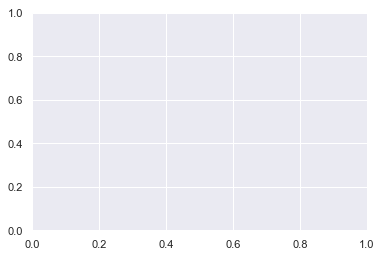

In [19]:
corr = df3.corr()

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr)

In [18]:
#Droppping unneeded columns and creating X and y
cols_to_drop = ['work_item','work_type', 'work_priority', 'domain', 'platform', 'components', 'start', 'end', 'duration', 
                'duration_in_days', 'duration_in_hours', 'duration_in_minutes', 'components_split', 'duration_in_seconds']

y = df3['duration_in_seconds']
X = df3.drop(df3[cols_to_drop], axis=1)

In [19]:
## Start of the ML stuff
# features_train, features_test, labels_train, labels_test = \
#     train_test_split(features, labels, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.3, random_state = 100)

In [20]:
print(y_train)

7935       166014.0
961          1388.0
2490      3213688.0
7658      1117719.0
8794       492600.0
6023      1190828.0
2551     15842327.0
3277     36978111.0
7282      1383290.0
7537     23680091.0
7827      4818257.0
6950        80003.0
2311        22616.0
10770     2570911.0
8201       342182.0
2681      6133263.0
9848      1205272.0
1245         5671.0
8637      4769364.0
7037      8485494.0
55        2761904.0
6959        10565.0
8072        87000.0
8571      1115600.0
6827       619057.0
6425     22964608.0
895       6202977.0
4973      6493255.0
3263      3016396.0
10252      334432.0
            ...    
5027      3066225.0
3883      2324450.0
4370      5768480.0
2965       368802.0
9754     11848795.0
6065       325647.0
7205      3977775.0
3302      3450716.0
5172      3969994.0
1964      2513474.0
6002           18.0
2507     27649049.0
6475      1964303.0
5983       934877.0
10322       10166.0
8129      5449113.0
1387      7872735.0
10753     3110638.0
10500      237190.0


In [21]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV 

In [46]:
svrl = svm.LinearSVR()
parameters = {}
clf_svrl = GridSearchCV(svrl, parameters, verbose = 1)
clf_svrl.fit(X_train, y_train)
pred_test = clf_svrl.predict(X_test)
pred_train = clf_svrl.predict(X_train)
# print(rmsle(y_train, pred_train))
# print(rmsle(y_test, pred_test))
score = clf_svrl.score(X_train, y_train)
score_test = clf_svrl.score(X_test, y_test)
print(score)
print(score_test)
# svr = svm.SVR()
# parameters = {}
# clf_svr = GridSearchCV(svr, parameters, verbose = 1)

# print("\nPerforming grid search for Decision Tree")
# print("parameters:")
# print(parameters)
# clf_svr.fit(X_train, y_train)
# pred = clf_svr.predict(X_test)
# accuracy = accuracy_score(pred,y_test)

# print(pred)
# print(accuracy)
#metrics

# ##Grid Search for Decision Tree
# DT = DecisionTreeClassifier()
# parameters = {'criterion' : ('gini', 'entropy'), 
#               'min_samples_split' : [2,3,4,5,6]}
# clf_dt = GridSearchCV(DT, parameters, verbose = 1)
# print("\nPerforming grid search for Decision Tree")
# print("parameters:")
# pprint(parameters)
# clf_dt.fit(features_train, labels_train)
# #Metrics
# print("\nBest score: {:0.3f}".format(clf_dt.best_score_))
# pred = clf_dt.predict(features_test)
# accuracy = accuracy_score(pred,labels_test)
# print ("\nAccuracy Score:"), accuracy
# print classification_report(labels_test,pred)
# print("\nBest parameters set:")
# best_parameters = clf_dt.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#     print("\t{}: {}".format(param_name, best_parameters[param_name]))

C:\Users\ljeffery\AppData\Local\Continuum\anaconda2\envs\Py3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s finished


-0.2947274385415597
-0.3080922529324259


In [ ]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)


train_predictions = pd.DataFrame(y_train)  
train_predictions['predictions'] = knn.predict(X_train)
test_predictions = pd.DataFrame(y_test)
test_predictions['predictions'] = knn.predict(X_test)
print(rmsle(y_train, train_predictions))
print(rmsle(y_test, test_predictions))